<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#radomly-assigned-treatment" data-toc-modified-id="radomly-assigned-treatment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>radomly assigned treatment</a></span><ul class="toc-item"><li><span><a href="#graph" data-toc-modified-id="graph-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>graph</a></span></li><li><span><a href="#monte-carlo" data-toc-modified-id="monte-carlo-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>monte carlo</a></span></li><li><span><a href="#results-display" data-toc-modified-id="results-display-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>results display</a></span></li></ul></li><li><span><a href="#confounder" data-toc-modified-id="confounder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>confounder</a></span><ul class="toc-item"><li><span><a href="#graph" data-toc-modified-id="graph-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>graph</a></span></li><li><span><a href="#monte-carlo" data-toc-modified-id="monte-carlo-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>monte carlo</a></span></li><li><span><a href="#results-display" data-toc-modified-id="results-display-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>results display</a></span></li></ul></li><li><span><a href="#3-selection-bias-into-the-treatment" data-toc-modified-id="3-selection-bias-into-the-treatment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3 selection bias into the treatment</a></span><ul class="toc-item"><li><span><a href="#graph" data-toc-modified-id="graph-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>graph</a></span></li><li><span><a href="#monte-carlo" data-toc-modified-id="monte-carlo-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>monte carlo</a></span></li><li><span><a href="#results-display" data-toc-modified-id="results-display-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>results display</a></span></li></ul></li></ul></div>

In [1]:

import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gr

sns.set_style("whitegrid")
sns.set_palette("Set2")

# radomly assigned treatment

+ covariate comes from standard normal distribution.
+ treatment is a randomly assigned 0 or 1 dummy variable.
+ a: means fit ols without covariate
+ b: means fit ols with covariate

+ example: 
    - covariate: income
    - treatment: gender
    - y: spending in IT products
    
    - y affected by both income and gender, higher income with higher spending, male with higher spending in IT products.

## graph

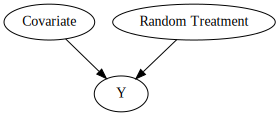

In [2]:
g=gr.Digraph()
g.edge("Covariate","Y")
g.edge("Random Treatment","Y")

g

## monte carlo

In [3]:
a1, b1 =0.5,2.5

coef_treatment_1_lst=[]

# different size N
N=[100,1000]

# different noise std
estd=[0.1, 0.5, 1, 2, 5]

# different sample size
for n in N:
    
    # different noise
    for e in estd:
    
        # run monte carlo in 200 times 
        for i in range(200):        
            
            # generate covariate
            X=np.random.normal(0,1,n)
            
            # generate random treatment
            treatment=np.random.randint(0,2,n)
            
            # errors from normal distribution
            e1=np.random.normal(0,1,n)
            e2=np.random.normal(0,e,n)
          
            # generate y, y is affected by covariate and random treatment
            y=(a1+b1*X+e1) + 0.5* treatment +e2

            # OLS estimation
            # do not control covariate
            model1=sm.OLS(y, sm.add_constant(treatment))
            res1=model1.fit()
            
            # do control covariate
            X2=np.hstack([X.reshape(-1,1),treatment.reshape(-1,1)])
            model2=sm.OLS(y, sm.add_constant(X2))
            res2=model2.fit()
            
            # make prediction
            y_pred1=res1.predict(sm.add_constant(X))
            y_pred2=res2.predict(sm.add_constant(X2))
            
            # calculate rmse
            rmse1=np.sqrt(np.mean((y-y_pred1)**2))
            rmse2=np.sqrt(np.mean((y-y_pred2)**2))
            
            # save a sample data
            if i==0:
                sample_df=pd.DataFrame(np.hstack([X2,y.reshape(-1,1)]),columns=["x","treatment","y"])
                sample_df.to_csv("simulated_sample_data/sample_data_A_N={}_BiasSTD={}.csv".format(n,e))

            # collecte treatment coefficient
            coef_treatment_1_lst.append({"size":n,"error std":e,"i":i,
                                         "treatment coef(no covariate)":res1.params[1],"treatment coef(with covariate)":res2.params[2],
                                         "rmse(no covariate)":rmse1,"rmse(with covariate)":rmse2})
    


print("One sample OLS Result:")
print(res1.summary())
print(res2.summary())

One sample OLS Result:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05860
Date:                Fri, 15 Apr 2022   Prob (F-statistic):              0.809
Time:                        22:44:19   Log-Likelihood:                -3162.2
No. Observations:                1000   AIC:                             6328.
Df Residuals:                     998   BIC:                             6338.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8576      0.

In [4]:
# transform collected fitting result as pandas dataframe

df_coef_treatment_1=pd.DataFrame(coef_treatment_1_lst)
df_coef_treatment_1.head()

,size,error std,i,treatment coef(no covariate),treatment coef(with covariate),rmse(no covariate),rmse(with covariate)
0,100,0.1,0,0.782005,0.223754,2.137066,0.812777
1,100,0.1,1,-0.051796,-0.055090,2.487800,0.977063
2,100,0.1,2,0.841570,0.703385,2.148957,1.073256
3,100,0.1,3,-0.269459,0.197137,3.380987,0.998925
4,100,0.1,4,0.246815,0.755051,2.308050,0.968849


## results display

**coefficient distribution of treatment by Monte Carlo**

1. when bias std is small, we can estimate the coefficient correctly, when bias std gets larger, the estimation mean has bigger bias.
2. larger sample size N can decrease the variance of estimated coefficient. 
3. with covariate controlled, the estimated coefficient has smaller variance.

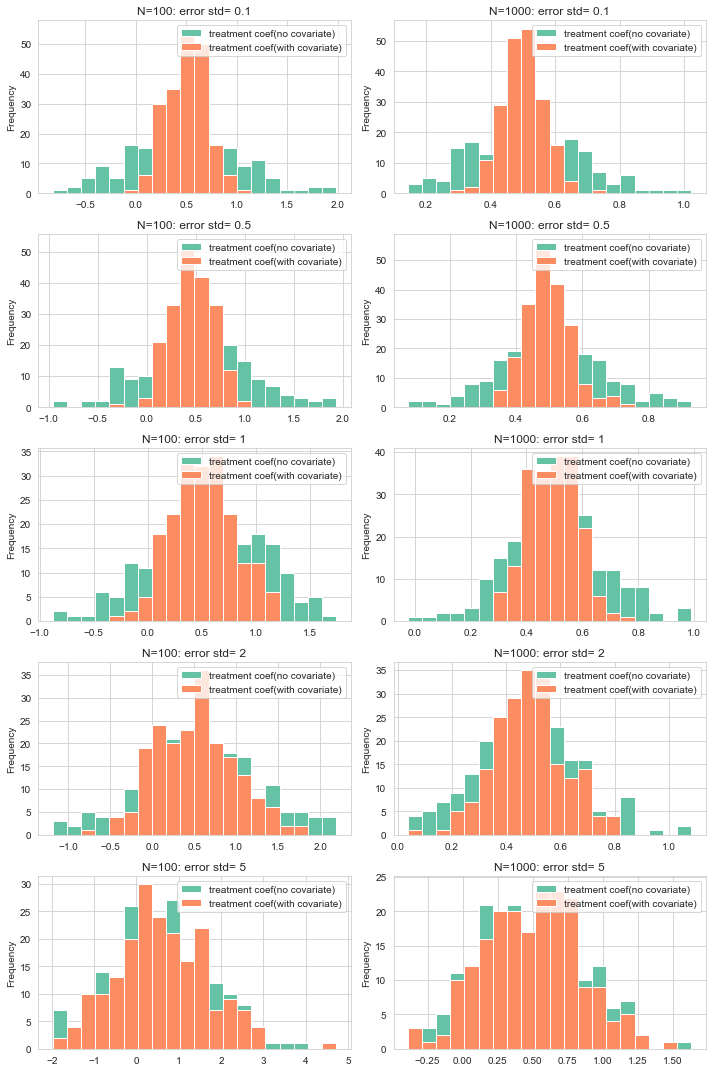

In [5]:
# coefficient distribution

fig,axs=plt.subplots(5,2,figsize=(10,15))

es=[0.1, 0.5, 1, 2, 5]
for i in range(5):
    
    df_coef_treatment_1[(df_coef_treatment_1["size"]==100)&(df_coef_treatment_1["error std"]==es[i])][["treatment coef(no covariate)","treatment coef(with covariate)"]].plot(kind="hist",bins=20,ax=axs[i,0])
    axs[i,0].set_title("N=100: error std= {}".format(es[i]))
    
    df_coef_treatment_1[(df_coef_treatment_1["size"]==1000)&(df_coef_treatment_1["error std"]==es[i])][["treatment coef(no covariate)","treatment coef(with covariate)"]].plot(kind="hist",bins=20,ax=axs[i,1])
    axs[i,1].set_title("N=1000: error std= {}".format(es[i]))
    
plt.tight_layout()

**RMSE distribution of OLS by Monte Carlo**

1. when bias std is small, RMSE is small, when bias increase, the RMSE increase.
2. larger sample size N can decrease the variance of RMSE.
3. RMSE with covariate controlled is smaller.

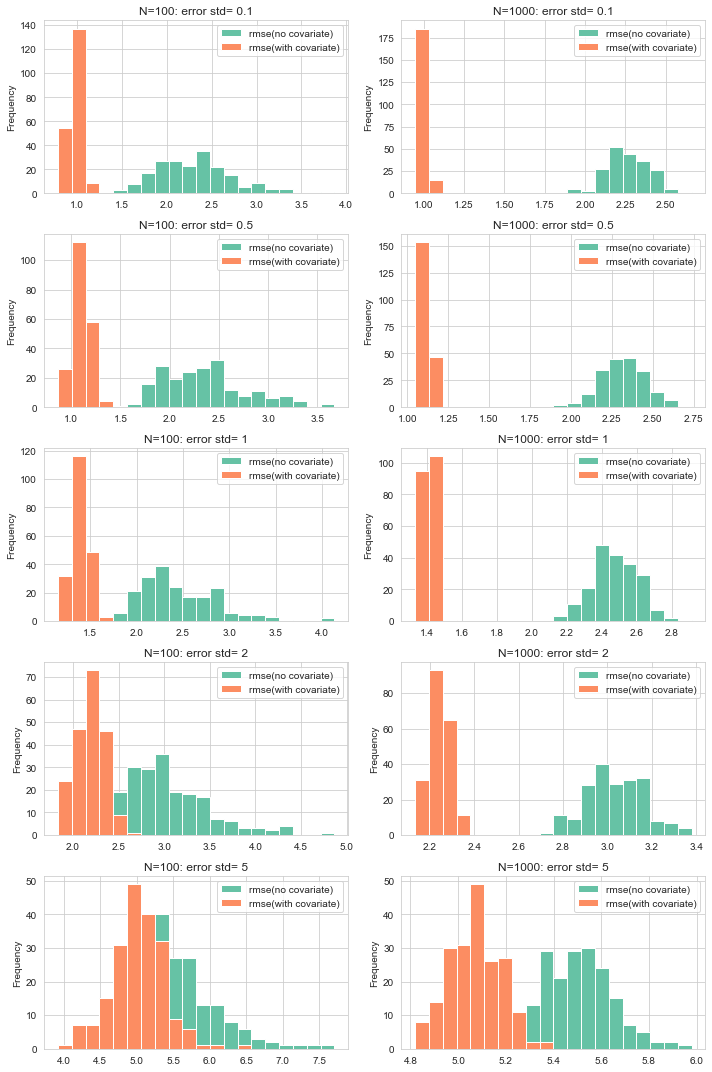

In [6]:
# rmse distribution

fig,axs=plt.subplots(5,2,figsize=(10,15))

es=[0.1, 0.5, 1, 2, 5]
for i in range(5):
    
    df_coef_treatment_1[(df_coef_treatment_1["size"]==100)&(df_coef_treatment_1["error std"]==es[i])][["rmse(no covariate)","rmse(with covariate)"]].plot(kind="hist",bins=20,ax=axs[i,0])
    axs[i,0].set_title("N=100: error std= {}".format(es[i]))
    
    df_coef_treatment_1[(df_coef_treatment_1["size"]==1000)&(df_coef_treatment_1["error std"]==es[i])][["rmse(no covariate)","rmse(with covariate)"]].plot(kind="hist",bins=20,ax=axs[i,1])
    axs[i,1].set_title("N=1000: error std= {}".format(es[i]))
    
plt.tight_layout()

# confounder

+ confounder comes from standard normal distribution.
+ confounder affects X
+ confounder affects Y
+ a: fail to control confounder: fit OLS with only X
+ b: do control for the confounder: fit OLS with X and confounder

+ example: 
    - covariate: age
    - X: working time per day
    - y: income
    
    - X is affected by age(the older may work less per day), y is also affected by age(the older may hive higher income),  and X affect y directly.

## graph

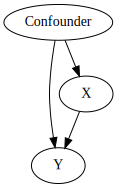

In [7]:
g=gr.Digraph()
g.edge("Confounder","Y")
g.edge("Confounder","X")
g.edge("X","Y")

g

## monte carlo

In [8]:
a1, b1 =0.5,0.5
a2, b2 =0.5,0.5
a3, b3 =0.5,0.5

coef_treatment_2_lst=[]

# different size N
N=[100,1000]

# different noise std
estd=[0.1, 0.5, 1, 2, 5]

# different sample size
for n in N:
    
    # different noise
    for e in estd:
    
        # run monte carlo in 200 times 
        for i in range(200):         
            
            # generate confounder
            confonder=np.random.normal(0,1,n)
            
            # errors from normal distribution
            e1=np.random.normal(0,1,n)
            e2=np.random.normal(0,1,n)
            e3=np.random.normal(0,e,n)

            # generate x, X is affected by confonder
            X=a1+b1*confonder+e1
            
            # generate y, y is affected by confonder and X
            y=(a2+b2*confonder+e2) + ( a3+b3*X) +e3

            # OLS estimation
            # fail to control confounder
            model1=sm.OLS(y, sm.add_constant(X))
            res1=model1.fit()
            
            # do control fonfounder
            X2=np.hstack([X.reshape(-1,1),confonder.reshape(-1,1)])
            model2=sm.OLS(y, sm.add_constant(X2))
            res2=model2.fit()
            
            # make prediction
            y_pred1=res1.predict(sm.add_constant(X))
            y_pred2=res2.predict(sm.add_constant(X2))
            
            # calculate rmse
            rmse1=np.sqrt(np.mean((y-y_pred1)**2))
            rmse2=np.sqrt(np.mean((y-y_pred2)**2))
            
            # save a sample data
            if i==0:
                sample_df=pd.DataFrame(np.hstack([X2,y.reshape(-1,1)]),columns=["x","confonder","y"])
                sample_df.to_csv("simulated_sample_data/sample_data_B_N={}_BiasSTD={}.csv".format(n,e))

            # collecte treatment coefficient
            coef_treatment_2_lst.append({"size":n,"error std":e,"i":i,"rmse fail":rmse1,"rmse do":rmse2})
    
df_coef_treatment_2=pd.DataFrame(coef_treatment_2_lst)
df_coef_treatment_2.head()

,size,error std,i,rmse fail,rmse do
0,100,0.1,0,1.095947,1.018832
1,100,0.1,1,1.189015,1.090868
2,100,0.1,2,1.113841,1.029277
3,100,0.1,3,1.184914,1.065847
4,100,0.1,4,0.950102,0.935635


## results display

1. when failed to control confounder, the rmse is larger, when controlled, the rmse decrease.
2. larger sample size N can lead to smaller rmse variance.
3. when Bias the rmse gets larger.

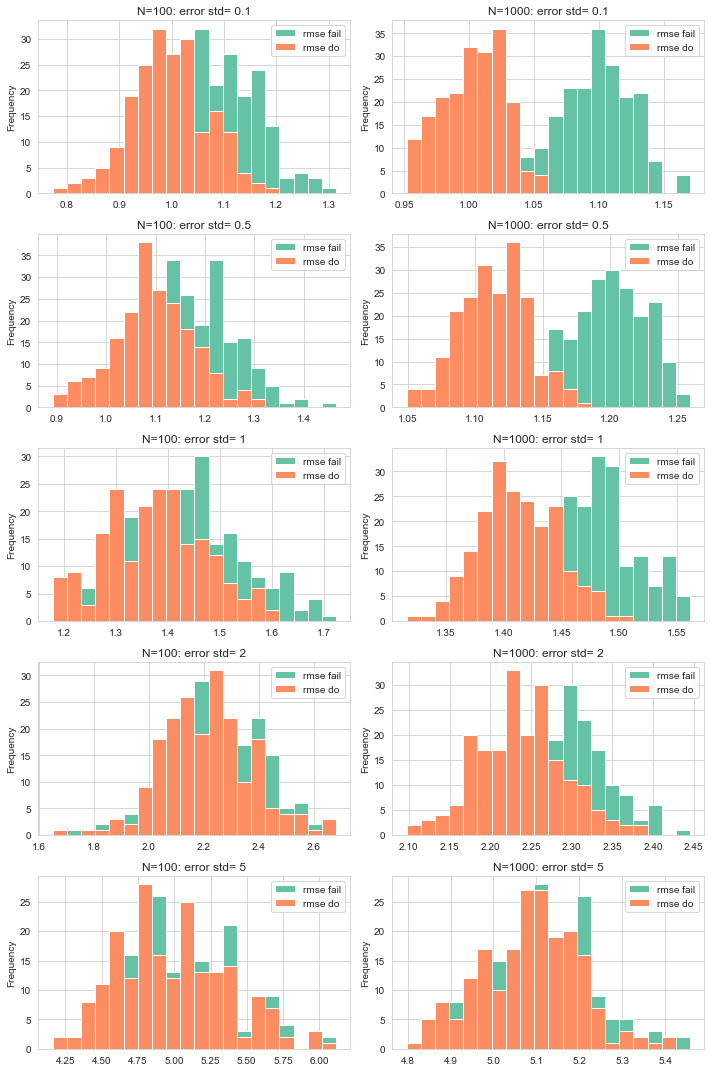

In [9]:
fig,axs=plt.subplots(5,2,figsize=(10,15))

es=[0.1, 0.5, 1, 2, 5]
for i in range(5):
    
    df_coef_treatment_2[(df_coef_treatment_2["size"]==100)&(df_coef_treatment_2["error std"]==es[i])][["rmse fail","rmse do"]].plot(kind="hist",bins=20,ax=axs[i,0])
    axs[i,0].set_title("N=100: error std= {}".format(es[i]))
    
    df_coef_treatment_2[(df_coef_treatment_2["size"]==1000)&(df_coef_treatment_2["error std"]==es[i])][["rmse fail","rmse do"]].plot(kind="hist",bins=20,ax=axs[i,1])
    axs[i,1].set_title("N=1000: error std= {}".format(es[i]))
    
plt.tight_layout()

# 3 selection bias into the treatment

+ X comes from standard normal distribution.
+ treatment is a 0 1 dummy variable, is affectted by X
+ treatment affects Y
+ X affects Y
+ a: control treatment, fit OLS with X and treatment.
+ b: do not control treatment, fit OLS with only X

+ example: 
    - X: income
    - treatment: living city
    - y: spending
    
    - treatment is affected by income(big city people have higher income), X affects spending, living city also affects spending.

## graph

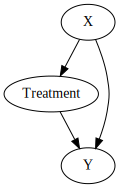

In [10]:
g=gr.Digraph()
g.edge("Treatment","Y")
g.edge("X","Treatment")
g.edge("X","Y")

g

## monte carlo

In [11]:
a1, b1 =0.5,1.2

coef_treatment_3_lst=[]

# different size N
N=[100,1000]

# different noise std
estd=[0.1, 0.5, 1, 2, 5]

# different sample size
for n in N:
    
    # different noise
    for e in estd:
    
        # run monte carlo in 200 times 
        for i in range(200):         
            
            # generate cause: X from normal distribution
            X=np.random.normal(0,1,n)

            # errors from normal distribution
            e1=np.random.normal(0,e,n)
            
            # selection bias
            selection_bias=np.where(X>0,1,0)

            # generate y
            y=selection_bias*1.5+ a1+b1*X+e1

            # OLS estimation
            # do not control selection_bias
            model1=sm.OLS(y, sm.add_constant(X))
            res1=model1.fit()
            
            # do control selection_bias
            X2=np.hstack([X.reshape(-1,1),selection_bias.reshape(-1,1)])
            model2=sm.OLS(y, sm.add_constant(X2))
            res2=model2.fit()
            
            # make prediction
            y_pred1=res1.predict(sm.add_constant(X))
            y_pred2=res2.predict(sm.add_constant(X2))
            
            # calculate rmse
            rmse1=np.sqrt(np.mean((y-y_pred1)**2))
            rmse2=np.sqrt(np.mean((y-y_pred2)**2))
            
            # save a sample data
            if i==0:
                sample_df=pd.DataFrame(np.hstack([X2,y.reshape(-1,1)]),columns=["x","treatment","y"])
                sample_df.to_csv("simulated_sample_data/sample_data_C_N={}_BiasSTD={}.csv".format(n,e))

            # collecte treatment coefficient
            coef_treatment_3_lst.append({"size":n,"error std":e,"i":i,"rmse fail":rmse1,"rmse do":rmse2})
    
df_coef_treatment_3=pd.DataFrame(coef_treatment_3_lst)
df_coef_treatment_3.head()
    

,size,error std,i,rmse fail,rmse do
0,100,0.1,0,0.437939,0.102937
1,100,0.1,1,0.438011,0.090902
2,100,0.1,2,0.489982,0.094222
3,100,0.1,3,0.475231,0.101550
4,100,0.1,4,0.461290,0.105158


## results display

1. with treatment controlled, the rmse is lower
2. with larger sample size N, the rmse is lower.
3. when Bias increase, the rmse increase and has larger variance.

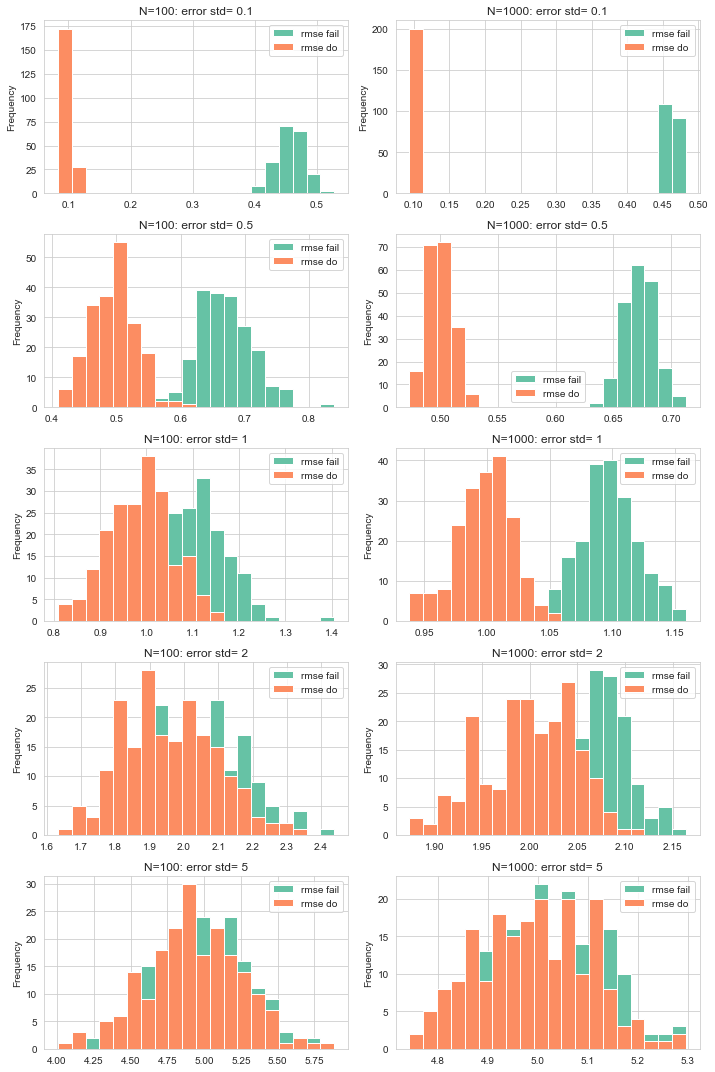

In [12]:
fig,axs=plt.subplots(5,2,figsize=(10,15))

es=[0.1, 0.5, 1, 2, 5]
for i in range(5):
    
    df_coef_treatment_3[(df_coef_treatment_3["size"]==100)&(df_coef_treatment_3["error std"]==es[i])][["rmse fail","rmse do"]].plot(kind="hist",bins=20,ax=axs[i,0])
    axs[i,0].set_title("N=100: error std= {}".format(es[i]))
    
    df_coef_treatment_3[(df_coef_treatment_3["size"]==1000)&(df_coef_treatment_3["error std"]==es[i])][["rmse fail","rmse do"]].plot(kind="hist",bins=20,ax=axs[i,1])
    axs[i,1].set_title("N=1000: error std= {}".format(es[i]))
    
plt.tight_layout()